In [46]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import wandb
import time
import matplotlib.pyplot as plt
import numpy as np

In [47]:
wandb.login(key="62cfafb7157dfba7fdd6132ac9d757ccd913aaaf")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [48]:
h_params =  {
    "epochs":10,
    "learning_rate":0.0001,
    "batch_size":32,
    "num_of_filter":64,
    "filter_size":[3,3,3,3,3],
    "actv_func":"gelu",
    "filter_multiplier":2,
    "data_augumentation":False,
    "batch_normalization":True,
    "dropout":0.4,
    "conv_layers":5,
    "dense_layer_size":256
}


IMAGE_SIZE = 224
NUM_OF_CLASSES = 10

In [49]:
def split_dataset_with_class_distribution(dataset, split_ratio):
    train_indices = []
    val_indices = []

    # Hardcoded class ranges based on the provided dataset
    class_ranges = [
        (0, 999),
        (1000, 1999),
        (2000, 2999),
        (3000, 3999),
        (4000, 4998),
        (4999, 5998),
        (5999, 6998),
        (6999, 7998),
        (7999, 8998),
        (8999, 9998)
    ]

    for start, end in class_ranges:
        class_indices = list(range(start, end + 1))
        split_idx = int(len(class_indices) * split_ratio)
        train_indices.extend(class_indices[:split_idx])
        val_indices.extend(class_indices[split_idx:])

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    return train_dataset, val_dataset

def prepare_data(h_params):
    desired_size = (IMAGE_SIZE, IMAGE_SIZE)

    if h_params["data_augumentation"]:
        train_transform = transforms.Compose([
            transforms.Resize(desired_size),  
             transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor()        
        ])
    else:
         train_transform = transforms.Compose([
            transforms.Resize(desired_size),  
            transforms.ToTensor()        
        ])

    test_transform = transforms.Compose([
        transforms.Resize(desired_size),  
        transforms.ToTensor()        
    ])

    train_data_dir = "/kaggle/input/nature/inaturalist_12K/train"
    test_data_dir = "/kaggle/input/nature/inaturalist_12K/val"
    train_dataset_total = ImageFolder(train_data_dir, transform=train_transform)
    train_dataset, validation_dataset = split_dataset_with_class_distribution(train_dataset_total, 0.8)

    test_dataset = ImageFolder(test_data_dir, transform=test_transform)
    train_len = len(train_dataset)
    val_len = len(validation_dataset)
    test_len = len(test_dataset)

    batch_size =h_params["batch_size"]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Return the datasets, loaders, and transforms as a dictionary
    return {
        "train_len": train_len,
        "val_len": val_len,
        "test_len": test_len,
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader
    }



#Preparing the data


In [50]:

class CNN(nn.Module):
    def __init__(self, h_params):
        super(CNN, self).__init__()
        self.h_params = h_params
        
        #create the no of fileters based on the multiplier
        self.filters =  []
        for i in range(5):
            self.filters.append(int(self.h_params["num_of_filter"]*(self.h_params["filter_multiplier"]**i)))
        print(self.filters)
        
        # Define convolutional layers
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        in_channels = 3
        for i in range(self.h_params["conv_layers"]):
            conv_layer = nn.Conv2d(in_channels, self.filters[i], self.h_params["filter_size"][i])
            self.conv_layers.append(conv_layer)
            if self.h_params["batch_normalization"]:
                self.bn_layers.append(nn.BatchNorm2d(self.filters[i]))
            in_channels = self.filters[i]
        
        #Define Fully connected layers
        f_map_side = self.neurons_in_dense_layer(self.h_params["filter_size"], IMAGE_SIZE)
        self.fc1 = nn.Linear( self.filters[-1]*f_map_side*f_map_side , self.h_params["dense_layer_size"])
        self.fc2 = nn.Linear(self.h_params["dense_layer_size"], NUM_OF_CLASSES)
        self.activation_func = self.get_activation_function(self.h_params["actv_func"])
        # Define dropout layer
        self.dropout = nn.Dropout(p=self.h_params["dropout"])

    def forward(self, x):
        for i in range(self.h_params["conv_layers"]):
            x = self.conv_layers[i](x)
            if self.h_params["batch_normalization"]:
                x = self.bn_layers[i](x)
            x = self.activation_func(x)
            x = F.max_pool2d(x, 2, 2)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
    def get_activation_function(self, activation_func_name):
        if activation_func_name == 'elu':
            return F.elu
        elif activation_func_name == 'gelu':
            return F.gelu
        elif activation_func_name == 'silu':
            return F.silu
        elif activation_func_name == 'selu':
            return F.selu
        elif activation_func_name == 'leaky_relu':
            return F.leaky_relu
    
    def neurons_in_dense_layer(self, filter_sizes, image_size):
        for i in range(5):
            image_size = int((image_size - filter_sizes[i] +1)/2)
        return image_size

In [51]:
def evaluate_testing_model(model,device, loader_data):
    # Set the model to evaluation mode
    model.eval()
    correct = 0
    test_loader =  loader_data["test_loader"]
    with torch.no_grad():  # Disable gradient calculation to speed up computations
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
            
          outputs = model(inputs)

          values, predicted = torch.max(outputs, 1)

          correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / loader_data["test_len"]

    print("Test accuracy: ", accuracy)


In [52]:
def generateGridImage(model, device, loader_data):

    # Initialize lists to store true labels, predicted labels, and images
    class_label_names = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]
    true_labels = []
    predicted_labels = []
    images = []

    # Get the first 30 data items from the test dataset
    test_loader = loader_data['test_loader']
    data_iterator = iter(test_loader)
    for i in range(30):
        inputs, labels = next(data_iterator)
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)

        # Compute predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        # Append images to the list after converting them from tensor to numpy array
        images.extend(inputs.cpu().numpy())

    # Create a grid of images with true and predicted labels
    fig, axs = plt.subplots(10, 3, figsize=(15, 50))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Convert from CHW to HWC format
        ax.axis('off')
        true_label_name = class_label_names[true_labels[i]]
        predicted_label_name = class_label_names[predicted_labels[i]]
        ax.set_title(f'\n\n\nTrue:{true_label_name}\nPredicted:{predicted_label_name}')

    plt.tight_layout()

    # Convert the plot to a wandb image
    wandb_image = wandb.Image(plt)

    # Log the image to wandb
    wandb.log({"Predictions": wandb_image})



In [53]:
def train(h_params, training_data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(h_params)
    model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=h_params["learning_rate"])
    train_len = training_data['train_len']
    val_len =  training_data['val_len']
    train_loader = training_data['train_loader']
    val_loader = training_data['val_loader']

    for epoch in range(h_params["epochs"]):
        training_loss = 0.0
        validation_loss = 0.0
        train_correct = 0
        validation_correct = 0
         # Training phase
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            training_loss+=loss.item()
            values, predicted = torch.max(outputs, 1)
            crt = (predicted == labels).sum().item() 
            train_correct += crt
            loss.backward()
            optimizer.step()
            if (i%10 == 0):
                print( "                            epoch  ", epoch, " batch ", i, " accuracy ", crt/labels.shape[0], " loss ", loss.item())

          
        # Validation phase
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                values, predicted = torch.max(outputs, 1)
                validation_correct += (predicted == labels).sum().item()
                validation_loss += loss.item()
        
        train_accuracy = train_correct/train_len
        train_loss  = training_loss/len(train_loader)
        validation_accuracy = validation_correct/val_len
        validation_loss = validation_loss/len(val_loader)
        print("epoch: ", epoch, "train accuray:",train_accuracy , "train loss:",train_loss , "val accuracy:", validation_accuracy,"val loss:",validation_loss)
        
        #logging to wandb
        wandb.log({"train_accuracy":train_accuracy, "train_loss":train_loss, "val_accuracy":validation_accuracy, "val_loss":validation_loss, "epoch":epoch})
    evaluate_testing_model(model,device,training_data)
    generateGridImage(model,device, training_data)

    print('Finished Training')
    PATH = './bestmodel.pth'
    torch.save(model.state_dict(), PATH)


[64, 128, 256, 512, 1024]
                            epoch   0  batch  0  accuracy  0.09375  loss  2.3913660049438477
                            epoch   0  batch  10  accuracy  0.125  loss  2.345008611679077
                            epoch   0  batch  20  accuracy  0.25  loss  2.071932077407837
                            epoch   0  batch  30  accuracy  0.125  loss  2.2595014572143555
                            epoch   0  batch  40  accuracy  0.15625  loss  2.203084707260132
                            epoch   0  batch  50  accuracy  0.21875  loss  2.352325201034546
                            epoch   0  batch  60  accuracy  0.3125  loss  2.1434834003448486
                            epoch   0  batch  70  accuracy  0.1875  loss  2.006237268447876
                            epoch   0  batch  80  accuracy  0.09375  loss  2.3829150199890137
                            epoch   0  batch  90  accuracy  0.125  loss  2.1908352375030518
                            epoch   0  batch  100  

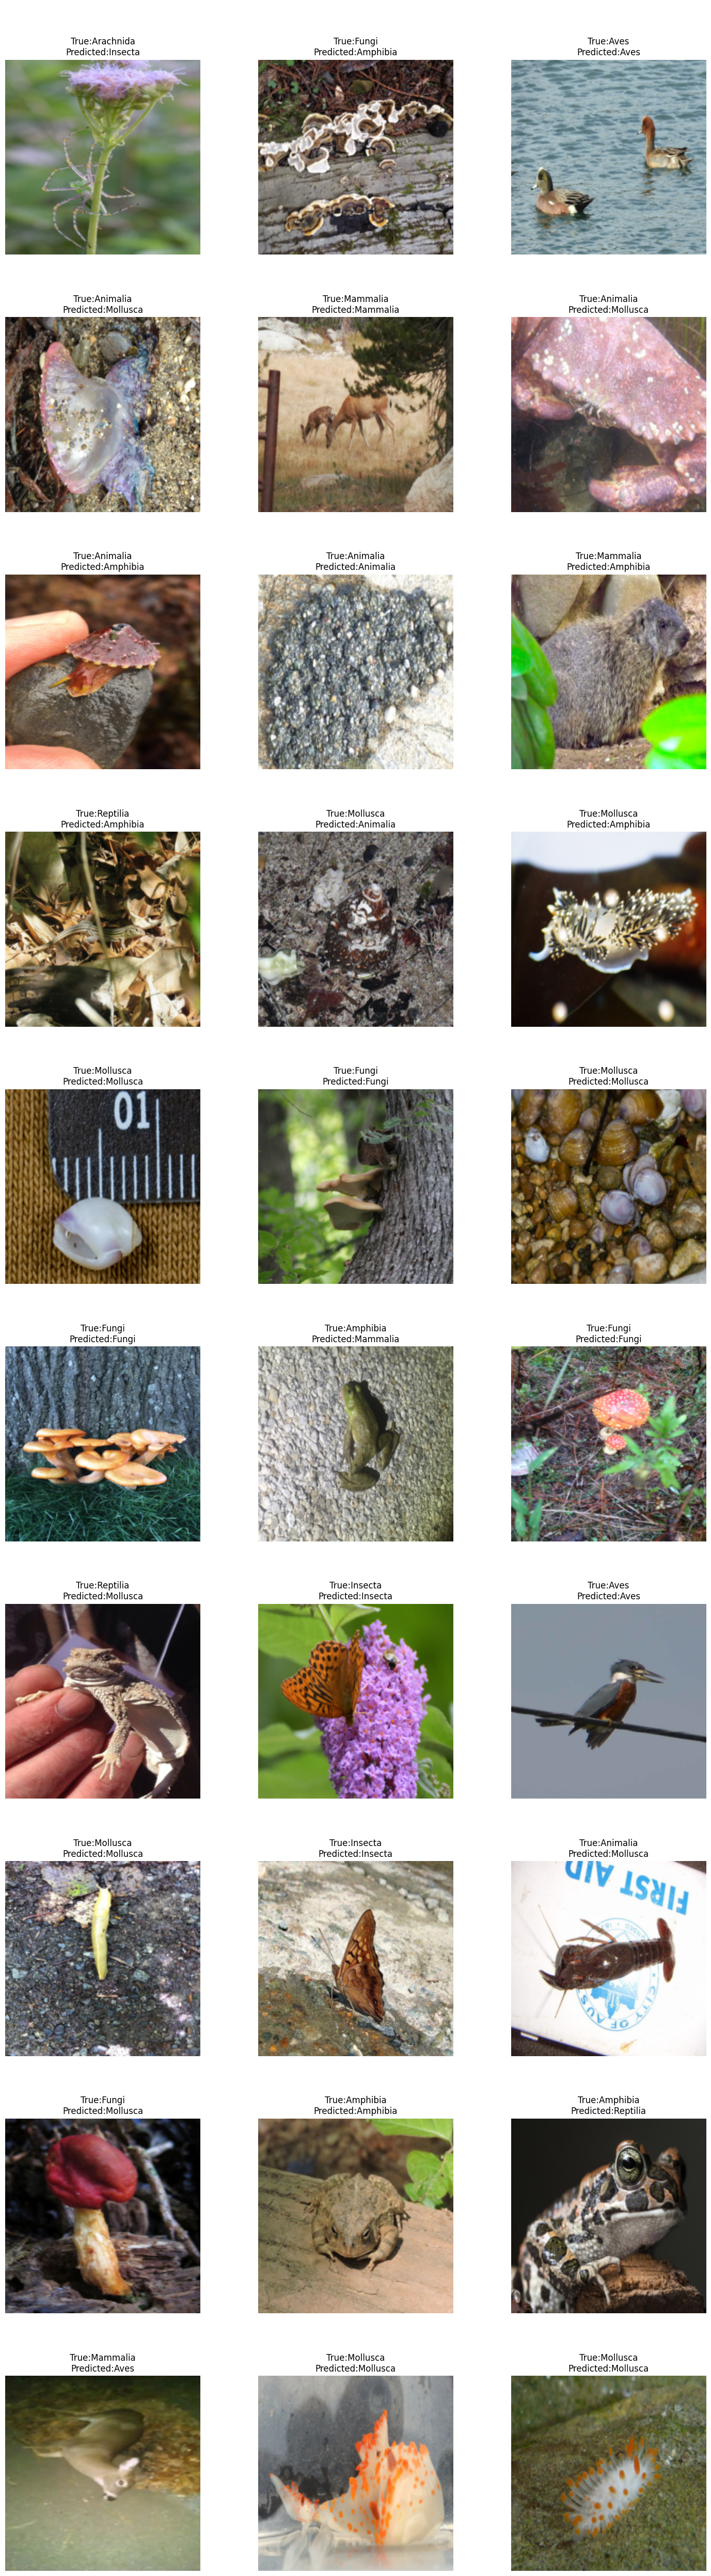

In [54]:
config = h_params

start_time = time.time()  # Record the start time
training_data = prepare_data(config)
run = wandb.init(project="DL Assignment 2", name=f"{config['actv_func']}_ep_{config['epochs']}_lr_{config['learning_rate']}_init_fltr_cnt_{config['num_of_filter']}_fltr_sz_{config['filter_size']}_fltr_mult_{config['filter_multiplier']}_data_aug_{config['data_augumentation']}_batch_norm_{config['batch_normalization']}_dropout_{config['dropout']}_dense_size_{config['dense_layer_size']}", config=config)
train(config, training_data) 
end_time = time.time()  # Record the end time
training_time = end_time - start_time
print(f"  Training time: {training_time/60} minutes , per epoch:{training_time/(60*10)} minutes")

In [55]:
sweep_params = {
    'method' : 'bayes',
    'name'   : 'DL assn 2 sweep',
    'metric' : {
        'goal' : 'maximize',
        'name' : 'val_accuracy',
    },
    'parameters' : {
        'epochs':{'values' : [10]},
        'learning_rate':{'values' : [0.0001, 0.001]},
        'batch_size':{'values':[32,64]},
        'num_of_filter':{'values' : [16,32,64] } ,
        'filter_size':{'values' : [[3,3,3,3,3], [5,5,5,5,5], [7,7,7,7,7], [11,9,7,5,3], [3,5,7,9,11]]},
        'actv_func':{'values':['elu','gelu','leaky_relu','selu']},
        'filter_multiplier':{'values' : [1,2]},
        'data_augumentation':{'values': [ False]},
        'batch_normalization':{'values' : [True, False]},
        'dropout':{'values': [0,0.1,0.2]},
        'dense_layer_size':{'values' : [64, 128,256]},
        'conv_layers':{'values':[5]}
    }
}

sweep_id = wandb.sweep(sweep=sweep_params, project="DL Assignment 2")
print(sweep_id)
def main():
    wandb.init(project="DL Assignment 2" )
    config = wandb.config
    start_time = time.time()  # Record the start time
    with wandb.init(project="DL Assignment 2", name=f"{config['actv_func']}_ep_{config['epochs']}_lr_{config['learning_rate']}_init_fltr_cnt_{config['num_of_filter']}_fltr_sz_{config['filter_size']}_fltr_mult_{config['filter_multiplier']}_data_aug_{config['data_augumentation']}_batch_norm_{config['batch_normalization']}_dropout_{config['dropout']}_dense_size_{config['dense_layer_size']}_batch_size_{config['batch_size']}", config=config ):
        training_data = prepare_data(config)  
        train(config,training_data)
    end_time = time.time()  # Record the end time
    training_time = end_time - start_time
    print(f"  Training time: {training_time/60} minutes , per epoch:{training_time/(60*10)} minutes")

Create sweep with ID: otrv12qq
Sweep URL: https://wandb.ai/jaswanth431/DL%20Assignment%202/sweeps/otrv12qq
otrv12qq


In [56]:
wandb.agent(sweep_id, function=main, count=10)
